In [1]:
import time

import cv2
import sys
import json

from torchvision.transforms.functional import to_tensor, to_pil_image
import torch
import warnings
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision.utils import make_grid

torch.autograd.set_grad_enabled(False)
torch.cuda.set_device(3)

sys.path.insert(0, '/home/zzhuang/AdaTrans')
sys.path.insert(0, '/home/zzhuang/AdaTrans/models/stylegan2')

from models.decoder import StyleGANDecoder
from models.e4e.psp_encoders import Encoder4Editing
from models.modules import Classifier
from models.ops import load_network, age2group
import tqdm
from models.modules import AdaTrans

In [2]:
stylegan2_checkpoint = '/home/zzhuang/AdaTrans/data/ffhq.pkl'
e4e_checkpoint = '/home/zzhuang/AdaTrans/data/e4e_ffhq_encode.pt'
classifier_checkpoint = '/home/zzhuang/AdaTrans/data/r50_a40_age_256_classifier.pth'
realnvp_checkpoint = '/home/zzhuang/AdaTrans/data/realnvp.pth'

G = StyleGANDecoder(
    stylegan2_checkpoint,
    start_from_latent_avg=False,
    output_size=256,
).eval().cuda()

encoder = Encoder4Editing(50, 'ir_se', stylegan_size=1024, checkpoint_path=e4e_checkpoint).eval().cuda()
image_classifier = Classifier(backbone='r50').eval().cuda()
image_classifier.load_state_dict(load_network(torch.load(classifier_checkpoint, map_location='cpu')))
from models.ops.lpips import LPIPS
from models.ops.id_loss import IDLoss
from models.modules import FLOW
LIPIPS_LOSS = LPIPS().cuda()
ID_LOSS = IDLoss(crop=True).cuda()
realnvp = FLOW(style_dim=G.style_dim, n_styles=G.n_styles, n_layer=10).cuda().eval()
realnvp.load_state_dict(torch.load(realnvp_checkpoint, map_location='cpu'))

Loading decoder weights from pretrained /home/zzhuang/AdaTrans/data/ffhq.pkl!


<All keys matched successfully>

In [3]:
from torchvision import transforms
img_size = 256
bs = 8
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

from models.dataset import dataset_dict
# dataset_type = dataset_dict['CelebA']
# data_root = '/home/zzhuang/DATASET/celeba-hq/celeba-256_ffhq'
dataset_type = dataset_dict['FFHQAge']
data_root = '/home/zzhuang/DATASET/FFHQ/images256x256'
test_dataset = dataset_type(data_root, img_size=img_size, split='test', transform=test_transform)
from models.ops import dataset_with_indices, load_network, age2group
test_loader = torch.utils.data.DataLoader(
    dataset_with_indices(test_dataset),
    batch_size=bs,
    shuffle=False,
    num_workers=8)

In [4]:
all_latents = []
for (images, _), _ in tqdm.tqdm(test_loader):
    images = images.cuda()
    with torch.no_grad():
        all_latents.append(encoder(images))
all_latents = torch.cat(all_latents, dim=0)
all_preds = []
for (images, _), _ in tqdm.tqdm(test_loader):
    images = images.cuda()
    with torch.no_grad():
        image_classifier.eval()
        preds = image_classifier(images)[0].sigmoid()
        all_preds.append(preds)
all_preds = torch.cat(all_preds, dim=0)
all_real_latents = all_latents + G.latent_avg
all_real_preds = (all_preds > 0.5).float()

100%|███████████████████████████████████████████| 98/98 [00:04<00:00, 21.51it/s]


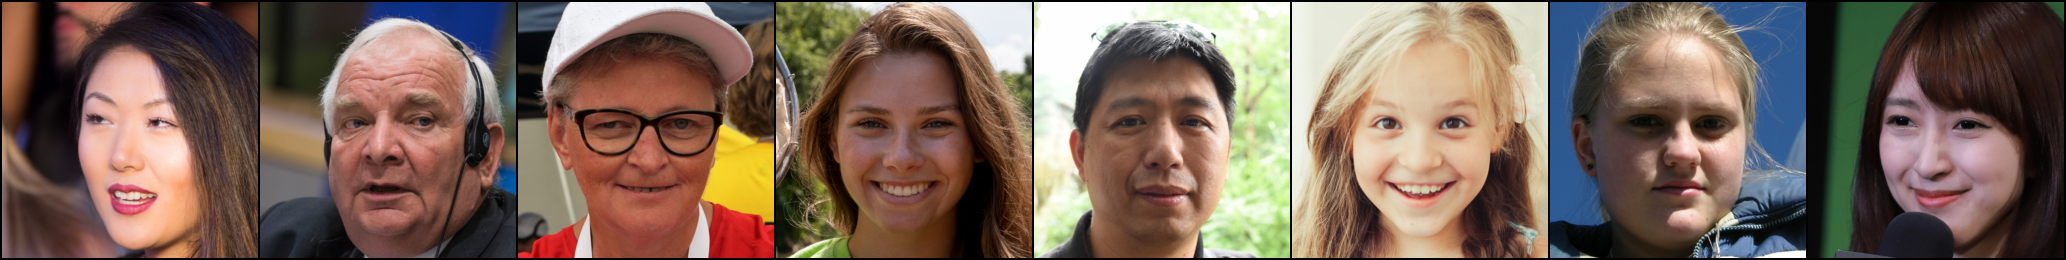

In [5]:
to_pil_image(make_grid(next(iter(test_loader))[0][0] * 0.5 + 0.5))

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


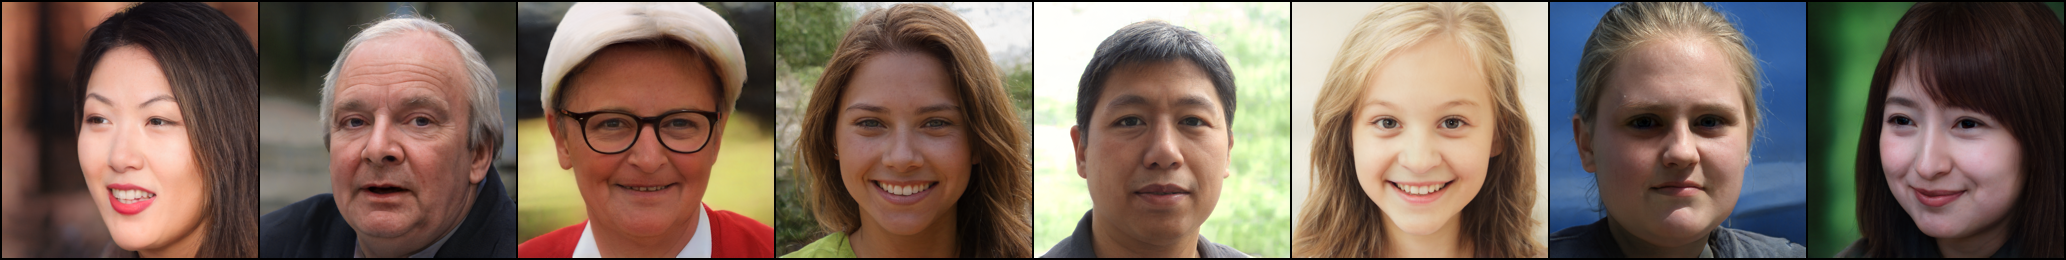

In [6]:
to_pil_image(make_grid(G(all_real_latents[:8]).clamp(-1, 1) * 0.5+0.5))

In [7]:
all_preds[:8]

tensor([[1.6493e-07, 5.8937e-01, 9.5121e-01, 3.0987e-02, 1.4332e-04, 1.5277e-04,
         3.8855e-01, 2.1376e-03, 2.8478e-01, 1.3565e-06, 1.3946e-06, 3.2969e-01,
         3.4312e-02, 1.3898e-04, 7.9269e-05, 1.3881e-04, 1.1272e-05, 1.2014e-07,
         9.7992e-01, 6.1575e-01, 8.7689e-05, 9.9999e-01, 3.9655e-05, 6.2702e-01,
         9.9997e-01, 2.2434e-01, 2.0466e-04, 2.6192e-01, 5.4073e-06, 3.3853e-02,
         6.1325e-07, 9.0489e-01, 8.4795e-01, 1.1608e-01, 3.6131e-03, 2.9116e-05,
         9.9956e-01, 5.2954e-02, 4.1113e-05, 9.9883e-01, 9.9999e-01, 9.9808e-01,
         4.6488e-01, 4.0325e-03, 1.4199e-05, 1.2646e-05],
        [2.6239e-04, 1.8509e-02, 5.7013e-04, 7.8735e-01, 7.9761e-01, 1.8084e-05,
         2.5848e-04, 9.2942e-01, 3.3070e-04, 2.9929e-03, 6.5512e-08, 6.6268e-04,
         5.7674e-03, 5.8398e-01, 7.5643e-01, 5.7628e-05, 1.6502e-05, 3.5766e-01,
         6.3436e-07, 4.7720e-01, 9.9999e-01, 8.5858e-01, 3.8046e-05, 3.4565e-02,
         9.9965e-01, 2.2714e-01, 4.7958e-03, 1.8138

In [8]:
class LatentAdaTrans(object):
    def __init__(self, attr_num, checkpoint, scale=1.0):
        self.attr_num = attr_num
        self.scale = scale
        model = AdaTrans(c_dim=1, max_steps=10, n_layers=10,
                             hid_dim=512, n_styles=G.n_styles,
                             style_dim=G.style_dim).eval().cuda()
        model.load_state_dict(load_network(torch.load(checkpoint, map_location='cpu')))
        self.model = model
        self.model.max_steps = int(scale)

    def transform(self, inputs, sources):
        targets_ = 1 - (sources[:, self.attr_num] > 0.5).float()
        targets_[targets_ == 0] = -1.
        trajectory, step_size = self.model(inputs, targets_.unsqueeze(1))
        new_styles = trajectory[-1]
        return new_styles

In [9]:
model_type = LatentAdaTrans
attr_num = 15
scale = 10.0
transformer = model_type(checkpoint='/home/zzhuang/AdaTrans/training/ckpt/15/save_models/model-latest', attr_num=attr_num, scale=scale)

In [10]:
all_real_preds

tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.]], device='cuda:3')

tensor(113, device='cuda:3')


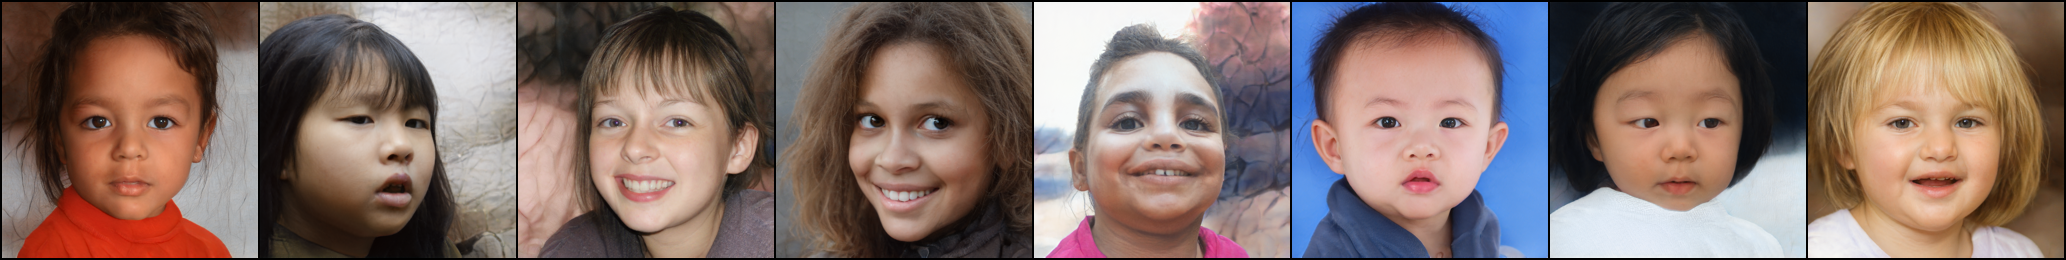

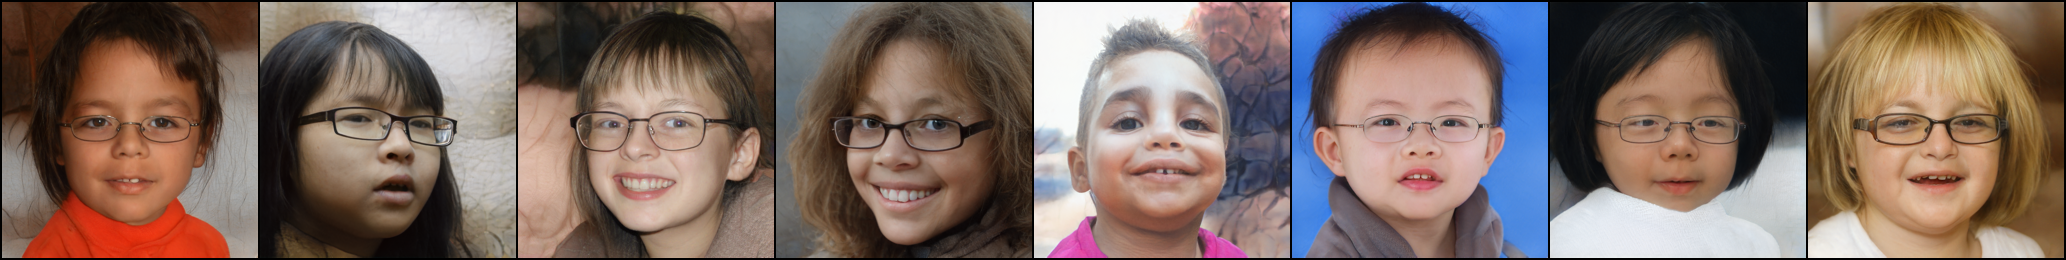

In [11]:
mask = ((all_real_preds[:, 40:] > 0.5).sum(dim=1) == 0)
print(mask.sum())
indices = torch.arange(len(all_real_preds)).cuda()
indices = indices[mask][torch.arange(8) + 4]
display(to_pil_image(make_grid(G(all_real_latents[indices]).clamp(-1, 1) * 0.5 + 0.5)))
display(to_pil_image(make_grid(G(transformer.transform(all_real_latents[indices], all_real_preds[indices])).clamp(-1, 1) * 0.5 + 0.5)))

In [12]:
def eval_single_attr(transformer):
    id_loss = 0.
    total = 0.
    all_editing_preds = []
    ll = 0.

    for (images, _), indices in tqdm.tqdm(test_loader):
        images = images.cuda()
        bs = images.size(0)
        latents = all_real_latents[indices]
        sources = all_real_preds[indices]
        new_styles = transformer.transform(latents, sources)
        new_images = G(new_styles).clamp(-1, 1)
        id_loss += ID_LOSS(images, new_images).item() * bs
        total += bs
        all_editing_preds.append(torch.sigmoid(image_classifier(new_images)[0]))

        realnvp.eval()
        ll += realnvp(new_styles)[0] * bs
    all_editing_preds = (torch.cat(all_editing_preds, dim=0) > 0.5).float()
    return id_loss / total, all_editing_preds, ll / total

In [13]:
scales = np.arange(0.2, 3.1, 0.2) * 5
display(scales)
model_type = LatentAdaTrans

attr_lis = [15, 20, 39]
checkpoints = [
    '/home/zzhuang/AdaTrans/training/ckpt/15/save_models/model-latest',
    '/home/zzhuang/AdaTrans/training/ckpt/20/save_models/model-latest',
    '/home/zzhuang/AdaTrans/training/ckpt/39/save_models/model-latest'
]
results = {}
for scale in scales:
    all_id_loss, all_editing_acc, all_attr_preserve_acc = [], [], []
    all_ll = []
    for i, attr_num in enumerate(attr_lis):
        transformer = model_type(attr_num=attr_num, checkpoint=checkpoints[i], scale=scale)

        id_loss, all_editing_preds, ll = eval_single_attr(transformer)
        editing_acc = (all_editing_preds[:, attr_num] == 1 - all_real_preds[:, attr_num]).float().mean().cpu().item()
        remaining_attr_indices = attr_lis.copy()
        remaining_attr_indices.remove(attr_num)
        attr_preserve_acc = (all_editing_preds[:, remaining_attr_indices] == all_real_preds[:, remaining_attr_indices]).float().mean(dim=0).cpu().numpy()

        all_id_loss.append(id_loss)
        all_editing_acc.append(editing_acc)
        all_attr_preserve_acc.append(attr_preserve_acc)
        all_ll.append(ll.item())
    display(scale, np.mean(all_editing_acc), np.mean(all_attr_preserve_acc), np.mean(all_id_loss), np.mean(all_ll))
    results[float(scale)] = {
        'editing_acc': float(np.mean(all_editing_acc)),
        'attr_preserve_acc': float(np.mean(all_attr_preserve_acc)),
        'id_loss': float(np.mean(all_id_loss)),
        'll': float(np.mean(all_ll)),
    }

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15.])

100%|███████████████████████████████████████████| 98/98 [00:12<00:00,  7.68it/s]


1.0

0.05491205553213755

0.966538

-0.6864123273335624

-0.08232155690590541

100%|███████████████████████████████████████████| 98/98 [00:12<00:00,  7.77it/s]


2.0

0.12097812443971634

0.96439296

-0.6803288791681861

-0.08180444190899532

100%|███████████████████████████████████████████| 98/98 [00:14<00:00,  6.95it/s]


3.0000000000000004

0.21535821755727133

0.96117544

-0.6676364682202479

-0.08011397471030553

100%|███████████████████████████████████████████| 98/98 [00:13<00:00,  7.16it/s]


4.0

0.3474903504053752

0.956242

-0.6484861260113007

-0.07716007282336552

100%|███████████████████████████████████████████| 98/98 [00:14<00:00,  6.83it/s]


5.0

0.4954954882462819

0.9551695

-0.6247198990310839

-0.07300076633691788

100%|███████████████████████████████████████████| 98/98 [00:14<00:00,  6.59it/s]


6.0

0.6426426668961843

0.95323896

-0.5996382456258457

-0.06779376789927483

100%|███████████████████████████████████████████| 98/98 [00:16<00:00,  5.95it/s]


7.000000000000001

0.7812098066012064

0.9534535

-0.575330399127029

-0.06174309675892194

100%|███████████████████████████████████████████| 98/98 [00:16<00:00,  6.04it/s]


8.0

0.8944659034411112

0.9513084

-0.5529425989042173

-0.05505234748125076

100%|███████████████████████████████████████████| 98/98 [00:17<00:00,  5.62it/s]


9.0

0.9485199650128683

0.9502359

-0.5331314281044678

-0.04789251585801443

100%|███████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


10.0

0.9734019637107849

0.9508794

-0.5155822703992794

-0.040383270010352135

100%|███████████████████████████████████████████| 98/98 [00:18<00:00,  5.23it/s]


11.0

0.9849850138028463

0.94637495

-0.5000536634859636

-0.03259650059044361

100%|███████████████████████████████████████████| 98/98 [00:21<00:00,  4.56it/s]


12.000000000000002

0.9918490052223206

0.945517

-0.48604516413323307

-0.02455837093293667

100%|███████████████████████████████████████████| 98/98 [00:19<00:00,  5.05it/s]


13.000000000000004

0.9931360085805258

0.943801

-0.47300291932074107

-0.016274226208527882

100%|███████████████████████████████████████████| 98/98 [00:20<00:00,  4.77it/s]


14.000000000000002

0.9939939975738525

0.9435864

-0.460381743952421

-0.007728215966684123

100%|███████████████████████████████████████████| 98/98 [00:20<00:00,  4.78it/s]


15.000000000000002

0.9961390097935995

0.9410124

-0.44824653089123195

0.0010910406708717346

/home/zzhuang/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/zzhuang/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

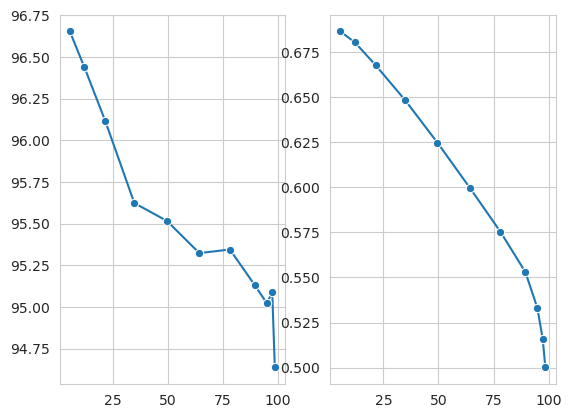

In [14]:
import seaborn as sns
x = np.array([results[k]['editing_acc'] for k in results])
y1 = np.array([results[k]['attr_preserve_acc'] for k in results])
y2 = np.array([results[k]['id_loss'] for k in results])
mask = x <= 0.99
x = x[mask] * 100
y1 = y1[mask] * 100
y2 = - y2[mask]
plt.subplot(1, 2, 1)
sns.lineplot(x, y1, marker='o')
plt.subplot(1, 2, 2)
sns.lineplot(x, y2, marker='o')